In [9]:
###################################################
# IMPORTANTE: Instalar la base de datos siguiendo #
# las instrucciones del README e indicar en estas #
# dos variables los direcctorios!!                #
TRAIN_REAL_DATA_PATH = "D:\Datos\TrainReal"
TRAIN_SIM_DATA_PATH  = "D:\Datos\TrainSimulation"
TEST_DATA_PATH       = "D:\Datos\TestReal"
###################################################
MODEL_PATH = "model"
OUTPUT_INFERENCE_PATH = "output"

import os
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

import torch
import torchvision.transforms as T
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from UAVIR_tools import BIRDSAIDataset, imgBoxes, createDir

# Si se encuentra disponible, seleccionamos GPU como dispositivo para entrenar
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Device: {}\n".format(device))

"""
Función que toma Faster-RCNN pre-entrenado y genera un nuevo modelo
aplicando un fine-tunning en el clasificador, adaptándolo al número
de clases, que debe de ser indicado en 'num_classes'. 
"""
def get_tunned_model(num_classes):
    # Cargamos el modelo
    model = fasterrcnn_resnet50_fpn()

    # Reemplazamos el clasificador de la red
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

"""
Función que nos retorna las transformaciones necesarias para codificar las
imágenes (en formato PIL), de tal forma que sean interpretables por la red.
"""
def get_transform():
    transforms = []
    transforms.append(T.PILToTensor())
    transforms.append(T.ConvertImageDtype(torch.float))
    return T.Compose(transforms) # __call__(<PIL image>)

Device: cuda



In [ ]:
# Cargamos el modelo
state_dict = torch.load(os.path.join(MODEL_PATH, "model_AUVIR_v0.4.pt"))
print("Pesos del modelo cargados!")

# Si el modelo ha sido guardado en versiones superiores de PyTorch,
# adaptamos los nombres de las capas para hacer el save compatible
# con la vensión instalada en la Jetson Nano.

for key in list(state_dict.keys()):
    new_key = key.replace('blocks.0.0.', 'blocks.0.')
    new_key = new_key.replace('blocks.1.0.', 'blocks.1.')
    new_key = new_key.replace('blocks.2.0.', 'blocks.2.')
    new_key = new_key.replace('blocks.3.0.', 'blocks.3.')
    new_key = new_key.replace('conv.0.0', 'conv')
    state_dict[new_key] = state_dict.pop(key)

# Importamos el modelo entrenado
num_classes = 3
model = get_tunned_model(num_classes)

model.to(device)
model.load_state_dict(state_dict)

del globals()["state_dict"]
print("Modelo importado!")

¡El directorio 'output' ya existe!


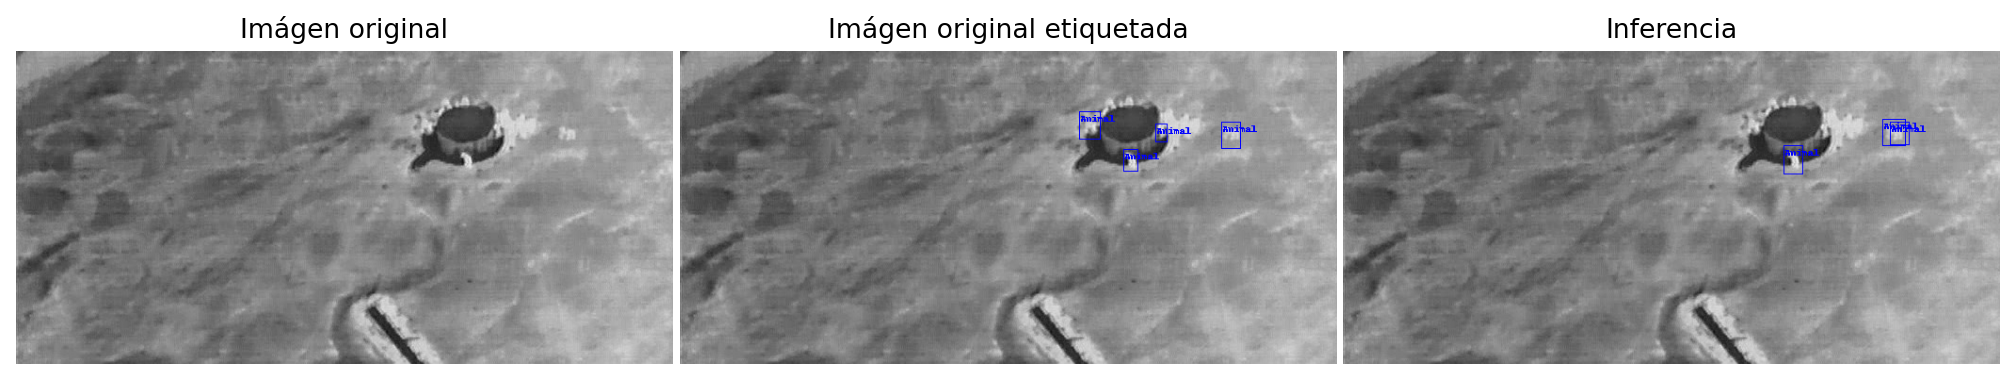

In [10]:
from PIL import Image

# Creamos el directorio donde vamos a guardar la salida
createDir(OUTPUT_INFERENCE_PATH)

# Transformaciones necesarias para que la entrada pueda
# ser interpretada por el modelo
transforms = get_transform()

# Cargamos la imágen
img_id = 1

imgs_path = "test_data"
img_path = os.path.join(imgs_path, list(sorted(os.listdir(imgs_path)))[img_id])

img = transforms(Image.open(img_path))
images = [img.to(device)]

# Inferimos
model_eval = model.eval()

print("Infiriendo...")
outputs = model_eval(images)

# Mostramos el resultado
FIGSIZE = [16, 9]
RES = 2560 # 2k

print("Mostrando la salida del modelo...")
transform_toImg = T.ToPILImage()
img = transform_toImg(img)

img_box = imgBoxes(img, outputs[0]["boxes"], outputs[0]["labels"], outputs[0]["scores"], 0.4)

fig = plt.figure(figsize=FIGSIZE, dpi=RES/FIGSIZE[0])
ax1, ax2 = fig.subplots(1,2)
plt.subplots_adjust(wspace=0.01)

ax1.axis('off')
ax2.axis("off")

ax1.set_title("Imágen original")
ax2.set_title("Inferencia")

ax1.imshow(img)
ax2.imshow(img_box)

plt.show()